# **FogML Time Series Data Classification For MCU**

## FogML installation

In [2]:
!pip install fogml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fogml.generators import GeneratorFactory

## Data preparation

In the example application for MCU, set `#define DATA_LOGGER` and collect data for various gestures/speeds/etc.

In [11]:
#Model 1
DATA = ["0_idle.csv", "1_circle.csv", "2_snake.csv"]
LABELS = ["IDLE", "CIRCLE", "SNAKE"]
MODEL_VERSION = 1

#Model 2
#DATA = ["0_idle.csv", "1_circle.csv", "2_snake.csv", "3_up_down.csv"]
#LABELS = ["IDLE", "CIRCLE", "SNAKE", "UP DOWN"]
#MODEL_VERSION = 2

## Random forrest model training

In [5]:
spX_t = []
spY_t = []

i = 0
for fname in DATA:
  tmp = pd.read_csv(fname, delimiter=" ", header=None)
  spX_t.append(tmp)
  spY_t.append([i] * tmp.shape[0])
  i = i + 1

spX = np.concatenate( spX_t, axis = 0 )
spY = np.concatenate( spY_t, axis = 0 )

print(spX.shape)
print(spY.shape)

(80, 12)
(80,)


In [6]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(spX, spY)
print( 'accuracy: ',clf.score(spX,spY))

accuracy:  1.0


# FogML Classifier Generation

In [7]:
factory = GeneratorFactory()
generator = factory.get_generator(clf)
generator.generate()

Copy generated `random_forrest_model.c` to the folder `fogml_generated` in the MCU project.


# FogML KMeans Anomaly Detector Generation

In [8]:
from sklearn.preprocessing import MinMaxScaler
from fogml.anomaly import KMeansAnomalyDetector
from fogml.generators import GeneratorFactory

scaler = MinMaxScaler()
transformer = scaler.fit(spX)
data_norm = transformer.transform(spX)

anomalyDetector = KMeansAnomalyDetector(n_clusters=16)
anomalyDetector.fit(data_norm)

factory = GeneratorFactory()
generator = factory.get_generator(transformer)
generator.generate(fname="min_max_scaler_model.c")

generator = factory.get_generator(anomalyDetector)
generator.generate(fname="kmeans_anomaly_model.c")

Copy generated `kmeans_anomaly_model.c` and `min_max_scaler_model.c` to the folder `fogml_generated` in the MCU project.

# Class Labels Generation

In [13]:
labels_pattern = 'const char* FOGML_LABELS[] = {{{}}};'
count_pattern = 'const int FOGML_LABELS_COUNT = {};'
version_pattern = 'const int FOGML_MODEL_VERSION = {};'

label = '"' + LABELS[0] + '"'

for i in range(1,len(LABELS)):
  label += ","
  label += '"' + LABELS[i] + '"'

print(labels_pattern.format(label))
print(count_pattern.format(len(LABELS)))
print(version_pattern.format(MODEL_VERSION))

const char* FOGML_LABELS[] = {"IDLE","CIRCLE","SNAKE"};
const int FOGML_LABELS_COUNT = 3;
const int FOGML_MODEL_VERSION = 1;


Copy and paste generated lines to the `fogml_config.h` file in lines below `//CLASSIFICATION` tag.

## Appendix - Feature Importance Analysis

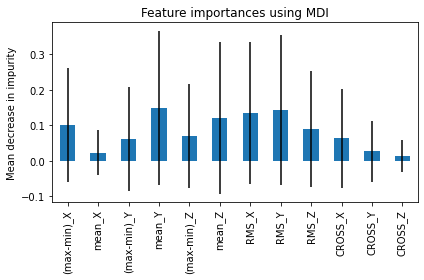

In [14]:
DSP_BLOCKS = ["BASE", "RMS", "CROSSINGS"]

DSP_BLOCKS_FEATURES = {"BASE": ["(max-min)_X", "mean_X", "(max-min)_Y", "mean_Y", "(max-min)_Z", "mean_Z"],
              "RMS": ["RMS_X", "RMS_Y", "RMS_Z"],
              "CROSSINGS": ["CROSS_X", "CROSS_Y", "CROSS_Z"]}

feature_names = ["(max-min)_X", "mean_X", "(max-min)_Y", "mean_Y", "(max-min)_Z", "mean_Z",
                 "RMS_X", "RMS_Y", "RMS_Z",
                 "CROSS_X", "CROSS_Y", "CROSS_Z"]


importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()